<h1>2-cd: Convolutional Neural Networks (ConvNets)</h1>

In [ ]:
#!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git
! wget https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py

--2022-11-17 19:36:30--  https://github.com/rdfia/rdfia.github.io/raw/master/code/2-cd/utils.py
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py [following]
--2022-11-17 19:36:30--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/2-cd/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627 (2.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.57K  --.-KB/s    in 0s      

2022-11-17 19:36:31 (52.4 MB/s) - ‘utils.py’ saved [2627/2627]



In [ ]:
%run 'utils.py'

In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim.lr_scheduler

from utils import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class ConvNet(nn.Module):
    """
    This class defines the structure of the neural network
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # We first define the convolution and pooling layers as a features extractor
        #self.features = nn.Sequential(
        #    nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
        #    nn.Tanh(),
        #    nn.MaxPool2d((2, 2), stride=2, padding=0),
        #    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
        #    nn.Tanh(),
        #    nn.MaxPool2d((2, 2), stride=2, padding=0),
        #)
        # We then define fully connected layers as a classifier
        #self.classifier = nn.Sequential(
        #    nn.Linear(400, 120),
        #    nn.Tanh(),
        #nn.Linear(120, 84),
        # nn.Tanh(),
        #  nn.Linear(84, 10)
        #   # Reminder: The softmax is included in the loss, do not put it here
        #)

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),  #conv 1: 32 convolutions 5 × 5, followed by ReLU
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),      #pool 1: max-pooling 2 × 2
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2), #conv 2: 64 convolutions 5 × 5, followed by ReLU
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),      #pool 2: max-pooling 2 × 2
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2), #conv 3: 64 convolutions 5 × 5, followed by ReLU
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0, ceil_mode=True),      #pool 3: max-pooling 2x2

        )
        # We then define fully connected layers as a classifier
        self.classifier = nn.Sequential(
            nn.Linear(1024, 1000),  #fc 4: fully-connected, 1000 output neurons, followed by ReLU
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000, 10)     #fc 5: fully-connected, 10 neurons output, followed by softmax
           # Reminder: The softmax is included in the loss, do not put it here
        )

    # Method called when we apply the network to an input batch
    def forward(self, input):
        bsize = input.size(0) # batch size
        output = self.features(input) # output of the conv layers
        output = output.view(bsize, -1) # we flatten the 2D feature maps into one 1D vector for each input
        output = self.classifier(output) # we compute the output of the fc layers
        return output



def get_dataset(batch_size, cuda=False):
    """
    This function loads the dataset and performs transformations on each
    image (listed in `transform = ...`).
    """
    #train_dataset = datasets.MNIST(PATH, train=True, download=True,
    #    transform=transforms.Compose([
    #        transforms.ToTensor()
    #    ]))
    #val_dataset = datasets.MNIST(PATH, train=False, download=True,
    #    transform=transforms.Compose([
    #        transforms.ToTensor()
    #    ]))

    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
      transform=transforms.Compose([
      # Set of transformations to apply, we have as input a PIL image (Python Image Library). Refer to the PyTorch documentation in the torchvision.transforms package
      transforms.ToTensor(), # Transform the PIL image to a torch.Tensor
      # Add normalization with values defined above
      transforms.Normalize([0.491, 0.482, 0.447], [0.202, 0.199, 0.201]),
      transforms.RandomCrop(28),
      transforms.RandomHorizontalFlip()
      ]))

    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
      transform=transforms.Compose([
      # Set of transformations to apply, we have as input a PIL image (Python Image Library). Refer to the PyTorch documentation in the torchvision.transforms package
      transforms.ToTensor(), # Transform the PIL image to a torch.Tensor
      # Add normalization with values defined above
      transforms.Normalize([0.491, 0.482, 0.447], [0.202, 0.199, 0.201]),
      transforms.CenterCrop(28)
      ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Make a pass (called epoch in English) on the data `data` with the
     model `model`. Evaluates `criterion` as loss.
     If `optimizer` is given, perform a training epoch using
     the given optimizer, otherwise, perform an evaluation epoch (no backward)
     of the model.
    """

    # indicates whether the model is in eval or train mode (some layers behave differently in train and eval)
    model.eval() if optimizer is None else model.train()

    # objects to store metric averages
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # we iterate on the batches
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # only with GPU, and not with CPU
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward if we are training
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # compute metrics
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # update
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # print info
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Print summary
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}

    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    if cuda: # only with GPU, and not with CPU
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # Get the data
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # We iterate on the epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Train phase
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        lr_sched.step()
        # Test phase
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar-10-python.tar.gz to datasets
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 6.782s (6.782s)	Loss 2.3021 (2.3021)	Prec@1  11.7 ( 11.7)	Prec@5  60.2 ( 60.2)


<Figure size 432x288 with 0 Axes>

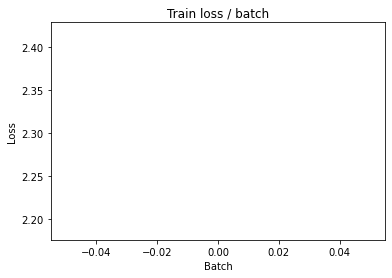

[TRAIN Batch 200/391]	Time 0.021s (0.069s)	Loss 1.4706 (1.6693)	Prec@1  50.0 ( 38.0)	Prec@5  90.6 ( 88.3)


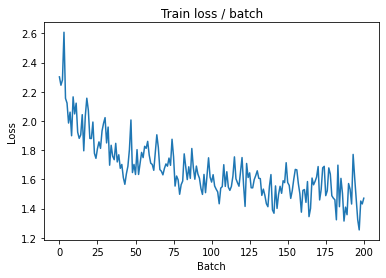


===============> Total time 20s	Avg loss 1.5263	Avg Prec@1 43.88 %	Avg Prec@5 90.74 %

[EVAL Batch 000/079]	Time 0.185s (0.185s)	Loss 1.3003 (1.3003)	Prec@1  54.7 ( 54.7)	Prec@5  93.8 ( 93.8)

===============> Total time 2s	Avg loss 1.4118	Avg Prec@1 50.37 %	Avg Prec@5 92.19 %



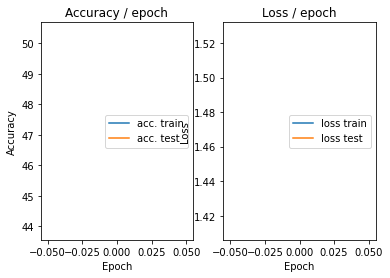

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.233s (0.233s)	Loss 1.4265 (1.4265)	Prec@1  44.5 ( 44.5)	Prec@5  95.3 ( 95.3)


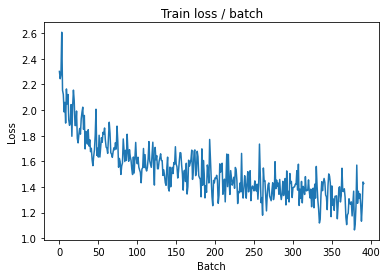

[TRAIN Batch 200/391]	Time 0.017s (0.039s)	Loss 1.3444 (1.2067)	Prec@1  60.9 ( 56.5)	Prec@5  91.4 ( 95.4)


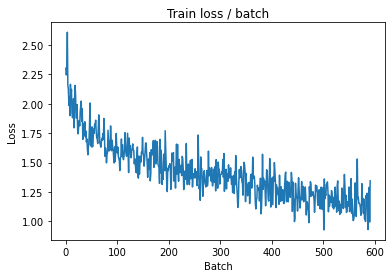


===============> Total time 15s	Avg loss 1.1553	Avg Prec@1 58.56 %	Avg Prec@5 95.76 %

[EVAL Batch 000/079]	Time 0.163s (0.163s)	Loss 1.0305 (1.0305)	Prec@1  62.5 ( 62.5)	Prec@5  96.1 ( 96.1)

===============> Total time 2s	Avg loss 0.9918	Avg Prec@1 64.90 %	Avg Prec@5 97.17 %



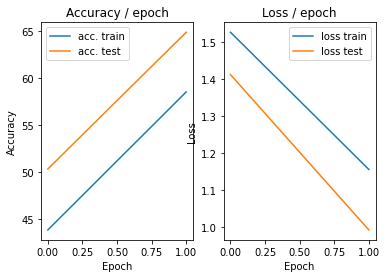

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.165s (0.165s)	Loss 1.0729 (1.0729)	Prec@1  59.4 ( 59.4)	Prec@5  97.7 ( 97.7)


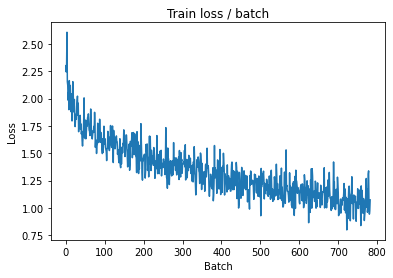

[TRAIN Batch 200/391]	Time 0.029s (0.037s)	Loss 0.9791 (1.0120)	Prec@1  59.4 ( 64.3)	Prec@5  98.4 ( 96.6)


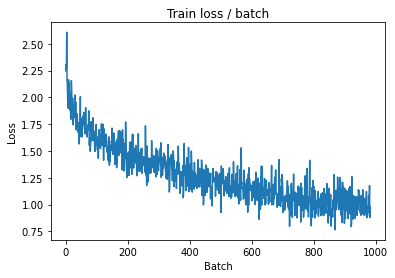


===============> Total time 14s	Avg loss 0.9908	Avg Prec@1 65.06 %	Avg Prec@5 96.79 %

[EVAL Batch 000/079]	Time 0.154s (0.154s)	Loss 0.9569 (0.9569)	Prec@1  68.8 ( 68.8)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 1.0046	Avg Prec@1 64.86 %	Avg Prec@5 96.67 %



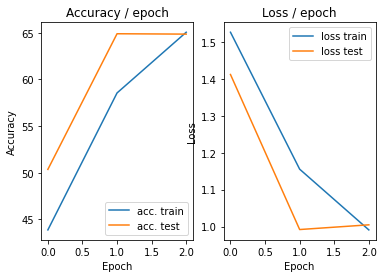

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.171s (0.171s)	Loss 0.8635 (0.8635)	Prec@1  68.0 ( 68.0)	Prec@5  99.2 ( 99.2)


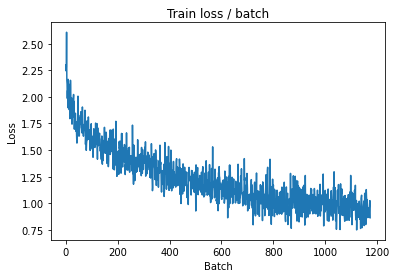

[TRAIN Batch 200/391]	Time 0.062s (0.038s)	Loss 0.8940 (0.9024)	Prec@1  68.8 ( 68.2)	Prec@5  96.9 ( 97.3)


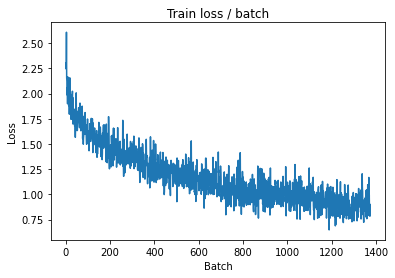


===============> Total time 14s	Avg loss 0.8892	Avg Prec@1 68.83 %	Avg Prec@5 97.41 %

[EVAL Batch 000/079]	Time 0.150s (0.150s)	Loss 0.7821 (0.7821)	Prec@1  72.7 ( 72.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.8115	Avg Prec@1 71.58 %	Avg Prec@5 98.20 %



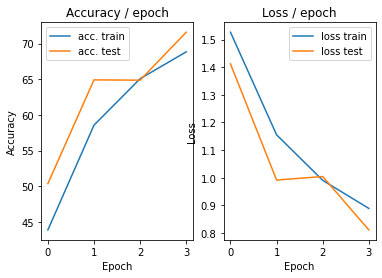

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.9364 (0.9364)	Prec@1  64.8 ( 64.8)	Prec@5  96.1 ( 96.1)


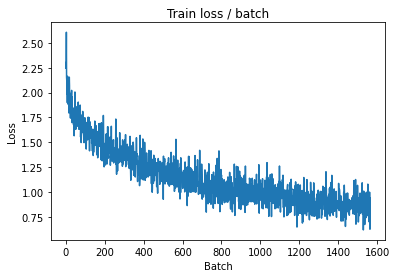

[TRAIN Batch 200/391]	Time 0.015s (0.044s)	Loss 0.7598 (0.8353)	Prec@1  72.7 ( 70.5)	Prec@5  98.4 ( 97.8)


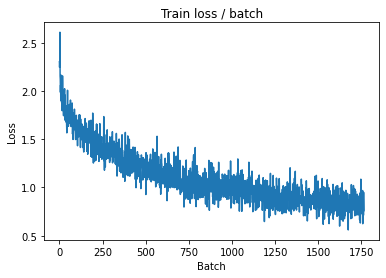


===============> Total time 15s	Avg loss 0.8149	Avg Prec@1 71.25 %	Avg Prec@5 97.90 %

[EVAL Batch 000/079]	Time 0.162s (0.162s)	Loss 0.7313 (0.7313)	Prec@1  76.6 ( 76.6)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8435	Avg Prec@1 70.32 %	Avg Prec@5 97.82 %



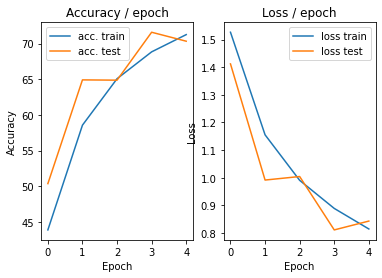

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.182s (0.182s)	Loss 0.8201 (0.8201)	Prec@1  73.4 ( 73.4)	Prec@5  97.7 ( 97.7)


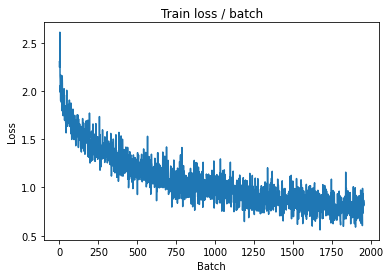

[TRAIN Batch 200/391]	Time 0.015s (0.038s)	Loss 0.6846 (0.7702)	Prec@1  73.4 ( 73.0)	Prec@5 100.0 ( 98.1)


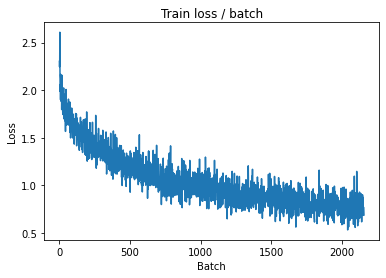


===============> Total time 14s	Avg loss 0.7567	Avg Prec@1 73.38 %	Avg Prec@5 98.19 %

[EVAL Batch 000/079]	Time 0.175s (0.175s)	Loss 0.8792 (0.8792)	Prec@1  75.0 ( 75.0)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.9374	Avg Prec@1 68.44 %	Avg Prec@5 97.44 %



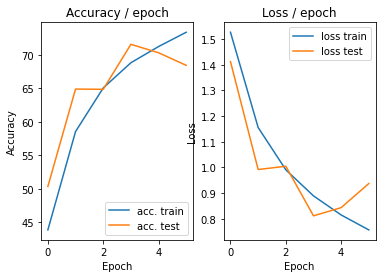

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.196s (0.196s)	Loss 0.6540 (0.6540)	Prec@1  76.6 ( 76.6)	Prec@5  99.2 ( 99.2)


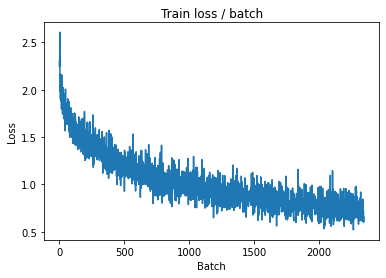

[TRAIN Batch 200/391]	Time 0.041s (0.037s)	Loss 0.8696 (0.7158)	Prec@1  65.6 ( 75.0)	Prec@5  98.4 ( 98.5)


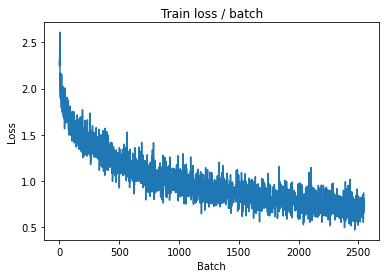


===============> Total time 14s	Avg loss 0.7128	Avg Prec@1 75.07 %	Avg Prec@5 98.47 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.6480 (0.6480)	Prec@1  78.1 ( 78.1)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.7013	Avg Prec@1 75.57 %	Avg Prec@5 98.58 %



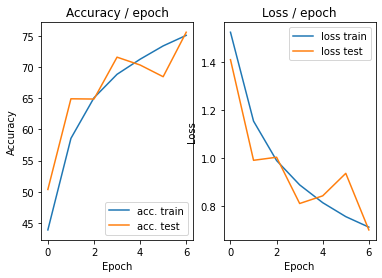

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 0.5947 (0.5947)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)


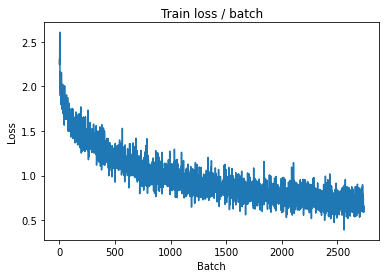

[TRAIN Batch 200/391]	Time 0.108s (0.040s)	Loss 0.6801 (0.6801)	Prec@1  75.8 ( 76.3)	Prec@5  97.7 ( 98.5)


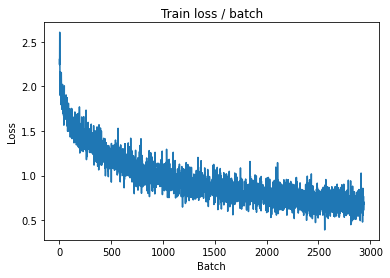


===============> Total time 15s	Avg loss 0.6737	Avg Prec@1 76.50 %	Avg Prec@5 98.48 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 0.6478 (0.6478)	Prec@1  78.1 ( 78.1)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6634	Avg Prec@1 77.36 %	Avg Prec@5 98.69 %



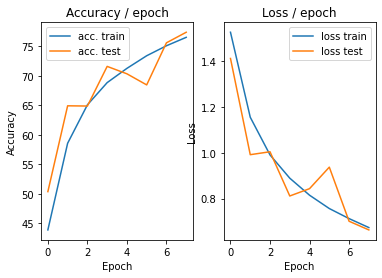

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.198s (0.198s)	Loss 0.6386 (0.6386)	Prec@1  75.0 ( 75.0)	Prec@5 100.0 (100.0)


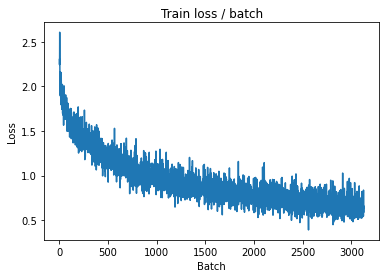

[TRAIN Batch 200/391]	Time 0.040s (0.038s)	Loss 0.8606 (0.6510)	Prec@1  70.3 ( 77.1)	Prec@5  98.4 ( 98.5)


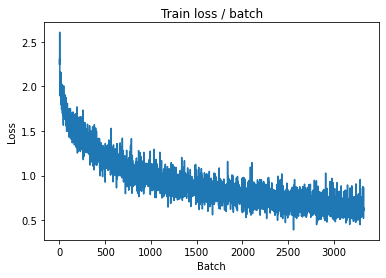


===============> Total time 14s	Avg loss 0.6438	Avg Prec@1 77.47 %	Avg Prec@5 98.58 %

[EVAL Batch 000/079]	Time 0.171s (0.171s)	Loss 0.6441 (0.6441)	Prec@1  78.9 ( 78.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6918	Avg Prec@1 76.07 %	Avg Prec@5 98.56 %



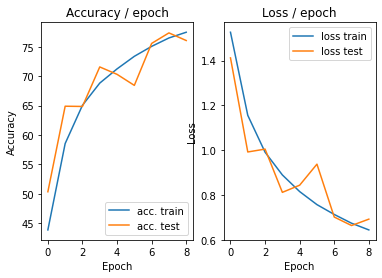

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.178s (0.178s)	Loss 0.5803 (0.5803)	Prec@1  78.9 ( 78.9)	Prec@5 100.0 (100.0)


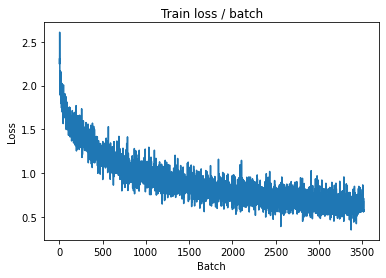

[TRAIN Batch 200/391]	Time 0.017s (0.038s)	Loss 0.6194 (0.6110)	Prec@1  79.7 ( 78.8)	Prec@5  99.2 ( 98.8)


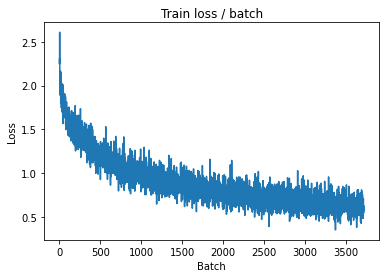


===============> Total time 14s	Avg loss 0.6123	Avg Prec@1 78.56 %	Avg Prec@5 98.85 %

[EVAL Batch 000/079]	Time 0.155s (0.155s)	Loss 0.5957 (0.5957)	Prec@1  79.7 ( 79.7)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.6341	Avg Prec@1 78.13 %	Avg Prec@5 98.66 %



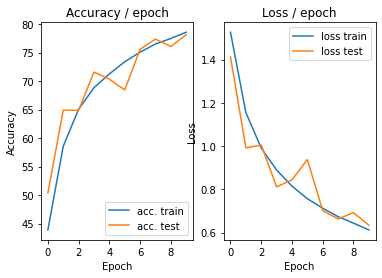

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.174s (0.174s)	Loss 0.5435 (0.5435)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)


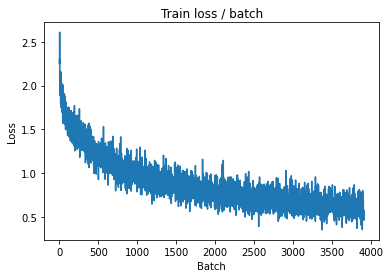

[TRAIN Batch 200/391]	Time 0.062s (0.037s)	Loss 0.4233 (0.5895)	Prec@1  86.7 ( 79.1)	Prec@5  99.2 ( 98.9)


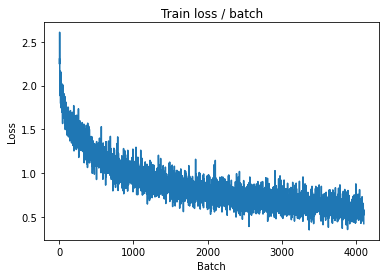


===============> Total time 15s	Avg loss 0.5897	Avg Prec@1 79.25 %	Avg Prec@5 98.92 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 0.8967 (0.8967)	Prec@1  68.8 ( 68.8)	Prec@5  97.7 ( 97.7)

===============> Total time 2s	Avg loss 0.8904	Avg Prec@1 70.00 %	Avg Prec@5 98.54 %



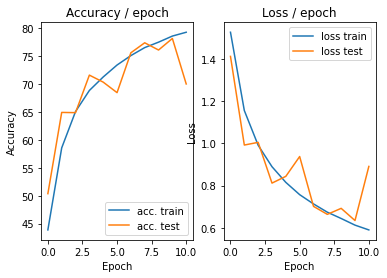

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.175s (0.175s)	Loss 0.5908 (0.5908)	Prec@1  76.6 ( 76.6)	Prec@5 100.0 (100.0)


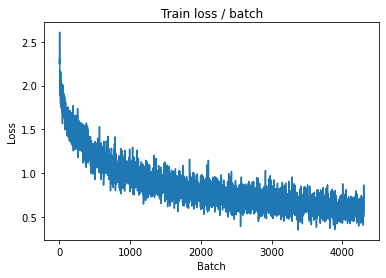

[TRAIN Batch 200/391]	Time 0.045s (0.037s)	Loss 0.5142 (0.5634)	Prec@1  83.6 ( 80.5)	Prec@5  99.2 ( 99.0)


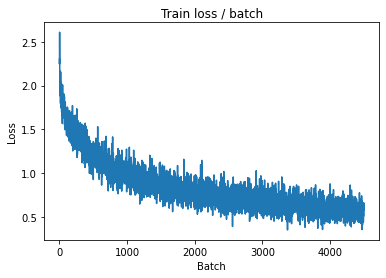


===============> Total time 14s	Avg loss 0.5657	Avg Prec@1 80.39 %	Avg Prec@5 98.93 %

[EVAL Batch 000/079]	Time 0.148s (0.148s)	Loss 0.5420 (0.5420)	Prec@1  84.4 ( 84.4)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6142	Avg Prec@1 78.70 %	Avg Prec@5 98.88 %



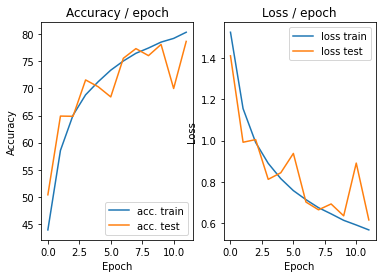

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.188s (0.188s)	Loss 0.4082 (0.4082)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


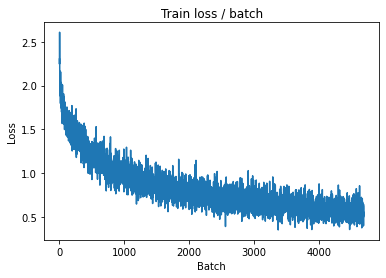

[TRAIN Batch 200/391]	Time 0.058s (0.038s)	Loss 0.5106 (0.5397)	Prec@1  79.7 ( 81.0)	Prec@5 100.0 ( 99.1)


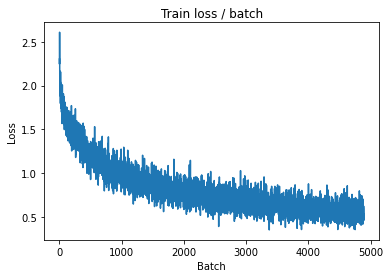


===============> Total time 14s	Avg loss 0.5416	Avg Prec@1 81.12 %	Avg Prec@5 99.08 %

[EVAL Batch 000/079]	Time 0.178s (0.178s)	Loss 0.5237 (0.5237)	Prec@1  80.5 ( 80.5)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.6003	Avg Prec@1 79.11 %	Avg Prec@5 98.70 %



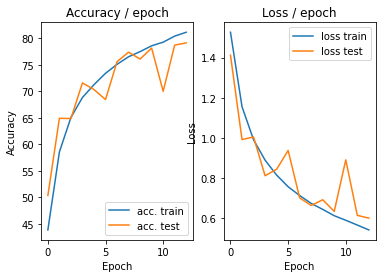

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.188s (0.188s)	Loss 0.4843 (0.4843)	Prec@1  82.8 ( 82.8)	Prec@5  99.2 ( 99.2)


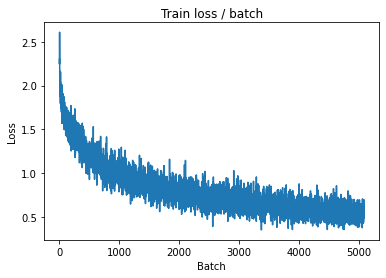

[TRAIN Batch 200/391]	Time 0.104s (0.041s)	Loss 0.4762 (0.5303)	Prec@1  84.4 ( 81.7)	Prec@5 100.0 ( 99.1)


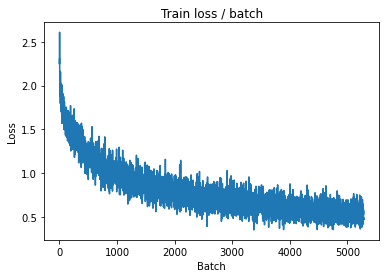


===============> Total time 15s	Avg loss 0.5313	Avg Prec@1 81.51 %	Avg Prec@5 99.13 %

[EVAL Batch 000/079]	Time 0.283s (0.283s)	Loss 0.5276 (0.5276)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6039	Avg Prec@1 79.01 %	Avg Prec@5 98.76 %



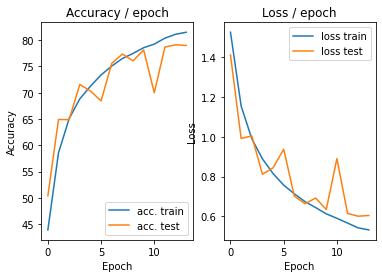

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 0.6131 (0.6131)	Prec@1  77.3 ( 77.3)	Prec@5  98.4 ( 98.4)


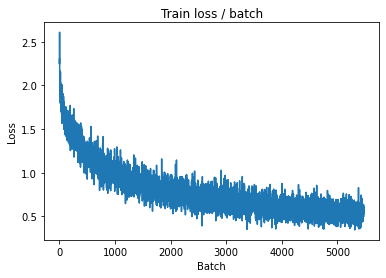

[TRAIN Batch 200/391]	Time 0.014s (0.037s)	Loss 0.5540 (0.5081)	Prec@1  80.5 ( 82.2)	Prec@5  98.4 ( 99.2)


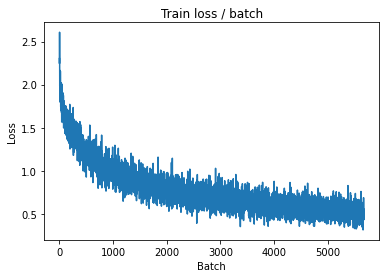


===============> Total time 14s	Avg loss 0.5113	Avg Prec@1 82.25 %	Avg Prec@5 99.16 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 0.5431 (0.5431)	Prec@1  86.7 ( 86.7)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.6712	Avg Prec@1 76.70 %	Avg Prec@5 98.50 %



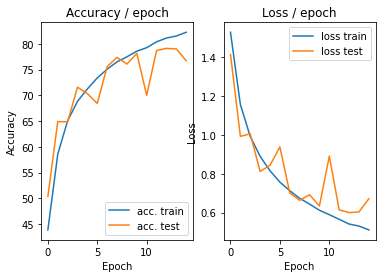

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.200s (0.200s)	Loss 0.5003 (0.5003)	Prec@1  78.1 ( 78.1)	Prec@5 100.0 (100.0)


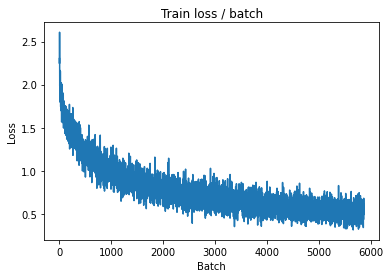

[TRAIN Batch 200/391]	Time 0.016s (0.037s)	Loss 0.5257 (0.4877)	Prec@1  83.6 ( 82.7)	Prec@5  99.2 ( 99.3)


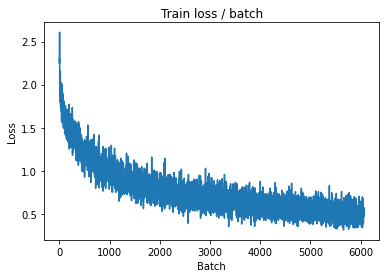


===============> Total time 14s	Avg loss 0.4944	Avg Prec@1 82.63 %	Avg Prec@5 99.23 %

[EVAL Batch 000/079]	Time 0.159s (0.159s)	Loss 0.5167 (0.5167)	Prec@1  80.5 ( 80.5)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5542	Avg Prec@1 80.97 %	Avg Prec@5 99.11 %



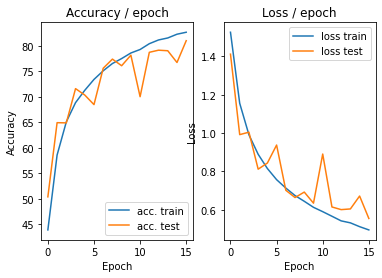

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 0.5354 (0.5354)	Prec@1  82.0 ( 82.0)	Prec@5  98.4 ( 98.4)


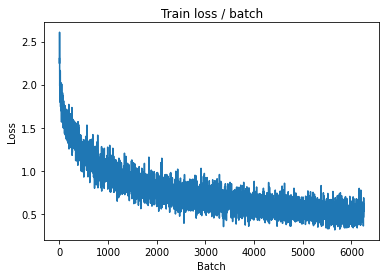

[TRAIN Batch 200/391]	Time 0.017s (0.038s)	Loss 0.4964 (0.4817)	Prec@1  83.6 ( 83.0)	Prec@5  96.9 ( 99.2)


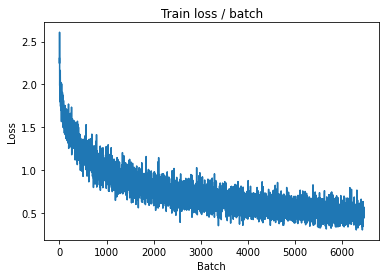


===============> Total time 14s	Avg loss 0.4806	Avg Prec@1 83.04 %	Avg Prec@5 99.24 %

[EVAL Batch 000/079]	Time 0.176s (0.176s)	Loss 0.5331 (0.5331)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5607	Avg Prec@1 80.70 %	Avg Prec@5 98.85 %



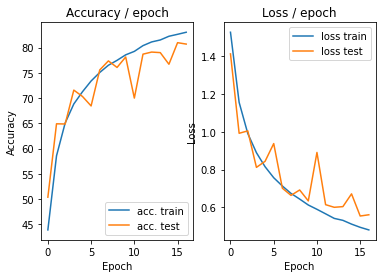

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.270s (0.270s)	Loss 0.4729 (0.4729)	Prec@1  81.2 ( 81.2)	Prec@5  99.2 ( 99.2)


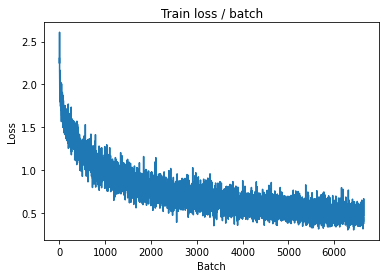

[TRAIN Batch 200/391]	Time 0.055s (0.039s)	Loss 0.4490 (0.4691)	Prec@1  85.9 ( 83.6)	Prec@5 100.0 ( 99.2)


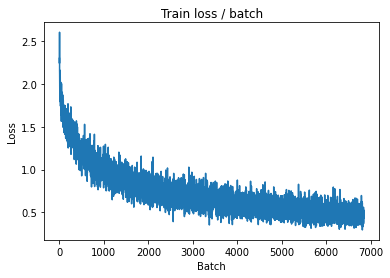


===============> Total time 14s	Avg loss 0.4688	Avg Prec@1 83.58 %	Avg Prec@5 99.32 %

[EVAL Batch 000/079]	Time 0.169s (0.169s)	Loss 0.4678 (0.4678)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5407	Avg Prec@1 81.09 %	Avg Prec@5 99.09 %



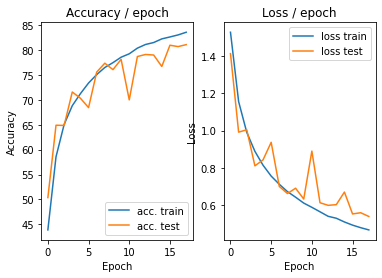

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.204s (0.204s)	Loss 0.5364 (0.5364)	Prec@1  84.4 ( 84.4)	Prec@5  99.2 ( 99.2)


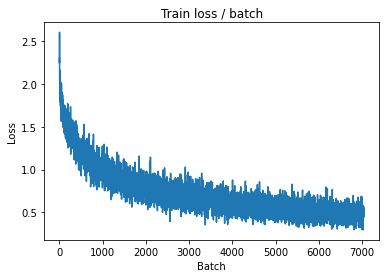

[TRAIN Batch 200/391]	Time 0.060s (0.037s)	Loss 0.3926 (0.4569)	Prec@1  85.2 ( 84.1)	Prec@5 100.0 ( 99.3)


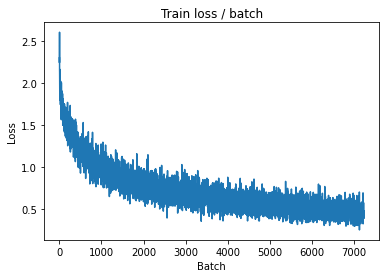


===============> Total time 14s	Avg loss 0.4565	Avg Prec@1 84.08 %	Avg Prec@5 99.32 %

[EVAL Batch 000/079]	Time 0.152s (0.152s)	Loss 0.4226 (0.4226)	Prec@1  85.9 ( 85.9)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5381	Avg Prec@1 81.58 %	Avg Prec@5 99.16 %



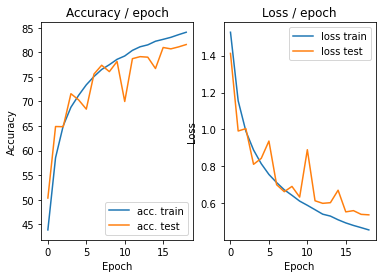

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.194s (0.194s)	Loss 0.3794 (0.3794)	Prec@1  85.9 ( 85.9)	Prec@5 100.0 (100.0)


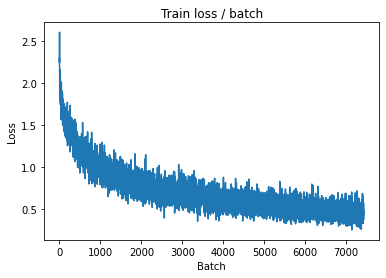

[TRAIN Batch 200/391]	Time 0.068s (0.037s)	Loss 0.4807 (0.4428)	Prec@1  84.4 ( 84.6)	Prec@5 100.0 ( 99.3)


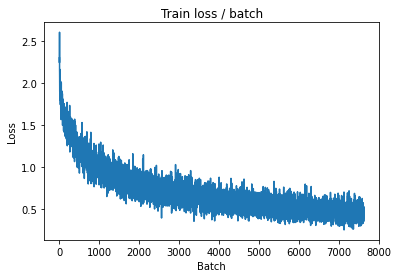


===============> Total time 14s	Avg loss 0.4456	Avg Prec@1 84.48 %	Avg Prec@5 99.35 %

[EVAL Batch 000/079]	Time 0.164s (0.164s)	Loss 0.4555 (0.4555)	Prec@1  85.9 ( 85.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5026	Avg Prec@1 82.81 %	Avg Prec@5 99.11 %



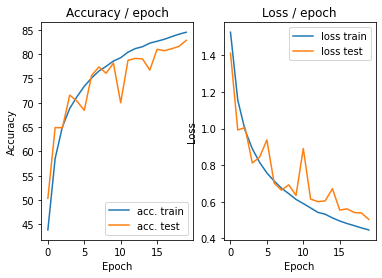

=== EPOCH 21 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.4577 (0.4577)	Prec@1  84.4 ( 84.4)	Prec@5 100.0 (100.0)


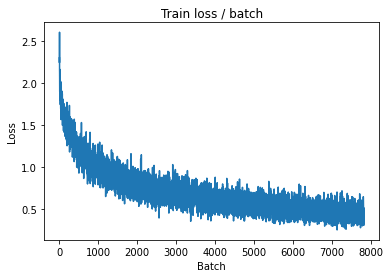

[TRAIN Batch 200/391]	Time 0.015s (0.042s)	Loss 0.4763 (0.4284)	Prec@1  84.4 ( 84.8)	Prec@5 100.0 ( 99.4)


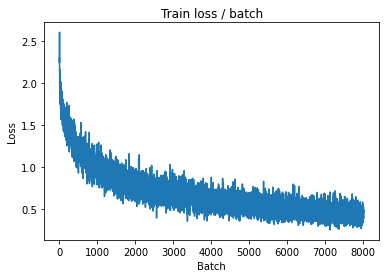


===============> Total time 15s	Avg loss 0.4328	Avg Prec@1 84.76 %	Avg Prec@5 99.38 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 0.4742 (0.4742)	Prec@1  85.9 ( 85.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5233	Avg Prec@1 82.19 %	Avg Prec@5 99.07 %



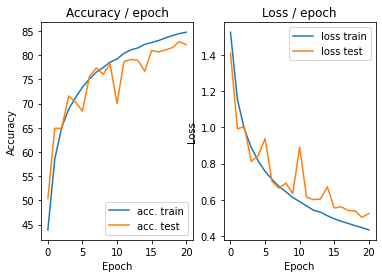

=== EPOCH 22 =====

[TRAIN Batch 000/391]	Time 0.193s (0.193s)	Loss 0.3777 (0.3777)	Prec@1  88.3 ( 88.3)	Prec@5  98.4 ( 98.4)


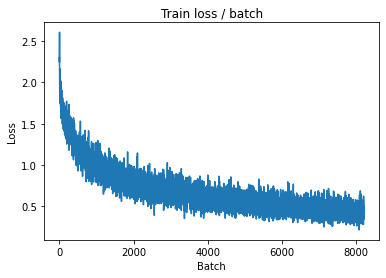

[TRAIN Batch 200/391]	Time 0.027s (0.037s)	Loss 0.4408 (0.4265)	Prec@1  85.2 ( 85.1)	Prec@5 100.0 ( 99.4)


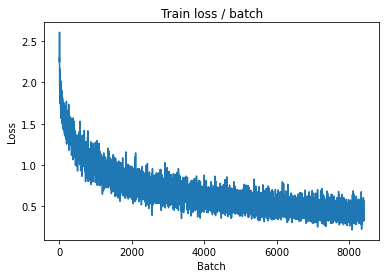


===============> Total time 14s	Avg loss 0.4264	Avg Prec@1 85.06 %	Avg Prec@5 99.42 %

[EVAL Batch 000/079]	Time 0.151s (0.151s)	Loss 0.4724 (0.4724)	Prec@1  83.6 ( 83.6)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.5696	Avg Prec@1 80.89 %	Avg Prec@5 99.07 %



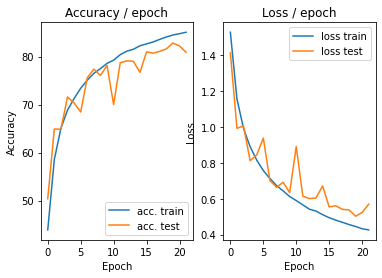

=== EPOCH 23 =====

[TRAIN Batch 000/391]	Time 0.183s (0.183s)	Loss 0.5467 (0.5467)	Prec@1  78.9 ( 78.9)	Prec@5  99.2 ( 99.2)


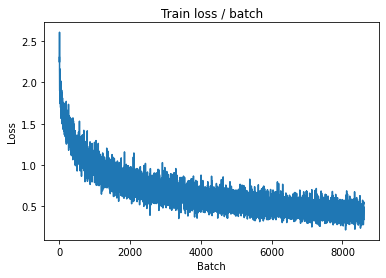

[TRAIN Batch 200/391]	Time 0.039s (0.037s)	Loss 0.2953 (0.4141)	Prec@1  90.6 ( 85.5)	Prec@5  99.2 ( 99.5)


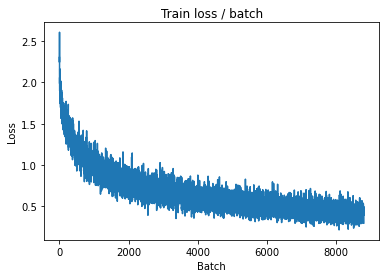


===============> Total time 14s	Avg loss 0.4141	Avg Prec@1 85.45 %	Avg Prec@5 99.48 %

[EVAL Batch 000/079]	Time 0.160s (0.160s)	Loss 0.4535 (0.4535)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5271	Avg Prec@1 82.15 %	Avg Prec@5 99.03 %



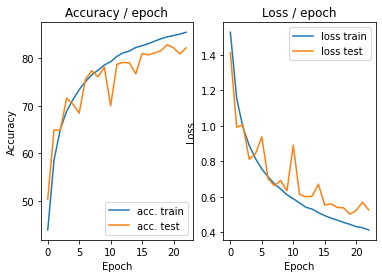

=== EPOCH 24 =====

[TRAIN Batch 000/391]	Time 0.195s (0.195s)	Loss 0.4523 (0.4523)	Prec@1  82.8 ( 82.8)	Prec@5 100.0 (100.0)


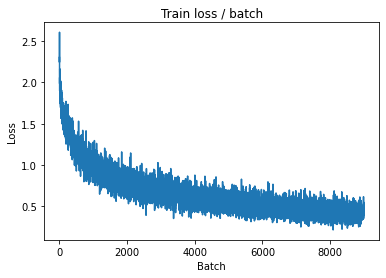

[TRAIN Batch 200/391]	Time 0.078s (0.044s)	Loss 0.4059 (0.4009)	Prec@1  85.9 ( 85.9)	Prec@5  99.2 ( 99.5)


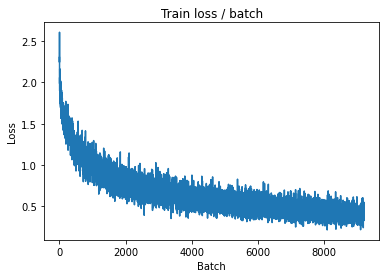


===============> Total time 15s	Avg loss 0.4078	Avg Prec@1 85.71 %	Avg Prec@5 99.50 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 0.4806 (0.4806)	Prec@1  84.4 ( 84.4)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5053	Avg Prec@1 82.61 %	Avg Prec@5 99.10 %



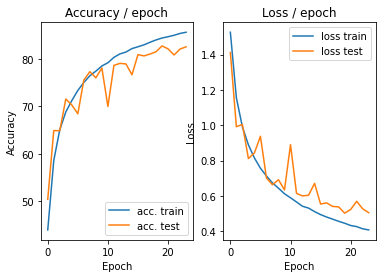

=== EPOCH 25 =====

[TRAIN Batch 000/391]	Time 0.194s (0.194s)	Loss 0.4548 (0.4548)	Prec@1  83.6 ( 83.6)	Prec@5 100.0 (100.0)


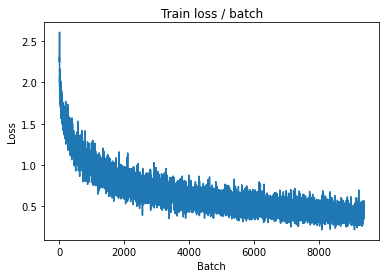

[TRAIN Batch 200/391]	Time 0.062s (0.038s)	Loss 0.3745 (0.3935)	Prec@1  85.9 ( 86.3)	Prec@5  99.2 ( 99.6)


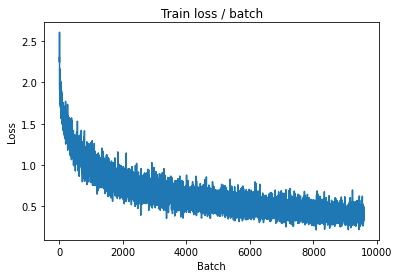


===============> Total time 14s	Avg loss 0.3977	Avg Prec@1 86.18 %	Avg Prec@5 99.53 %

[EVAL Batch 000/079]	Time 0.175s (0.175s)	Loss 0.4264 (0.4264)	Prec@1  85.2 ( 85.2)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5176	Avg Prec@1 82.42 %	Avg Prec@5 98.97 %



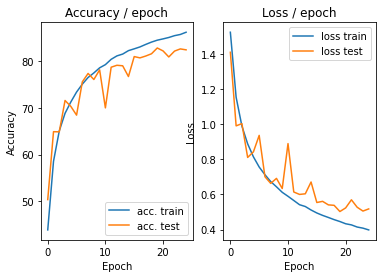

=== EPOCH 26 =====

[TRAIN Batch 000/391]	Time 0.207s (0.207s)	Loss 0.4124 (0.4124)	Prec@1  87.5 ( 87.5)	Prec@5 100.0 (100.0)


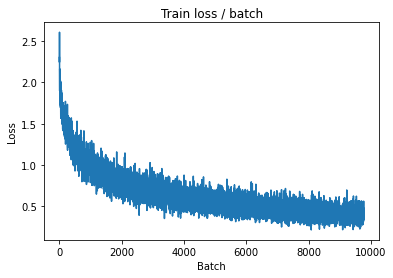

[TRAIN Batch 200/391]	Time 0.029s (0.038s)	Loss 0.3726 (0.3918)	Prec@1  88.3 ( 86.2)	Prec@5  99.2 ( 99.5)


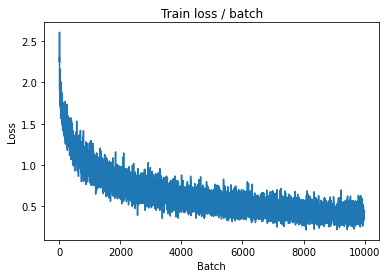


===============> Total time 14s	Avg loss 0.3912	Avg Prec@1 86.29 %	Avg Prec@5 99.58 %

[EVAL Batch 000/079]	Time 0.165s (0.165s)	Loss 0.3960 (0.3960)	Prec@1  85.9 ( 85.9)	Prec@5  98.4 ( 98.4)

===============> Total time 3s	Avg loss 0.4743	Avg Prec@1 83.53 %	Avg Prec@5 99.20 %



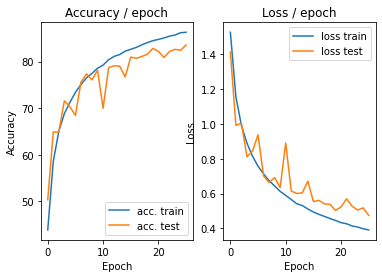

=== EPOCH 27 =====

[TRAIN Batch 000/391]	Time 0.219s (0.219s)	Loss 0.3412 (0.3412)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


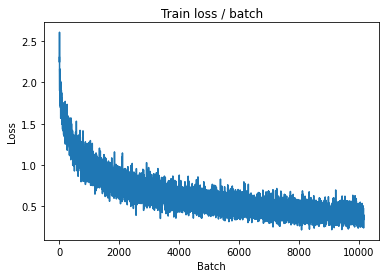

[TRAIN Batch 200/391]	Time 0.068s (0.038s)	Loss 0.4074 (0.3805)	Prec@1  88.3 ( 87.0)	Prec@5  98.4 ( 99.5)


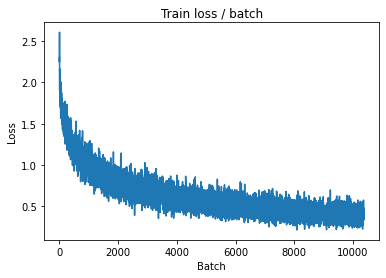


===============> Total time 15s	Avg loss 0.3815	Avg Prec@1 86.77 %	Avg Prec@5 99.54 %

[EVAL Batch 000/079]	Time 0.158s (0.158s)	Loss 0.4232 (0.4232)	Prec@1  86.7 ( 86.7)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.4841	Avg Prec@1 83.42 %	Avg Prec@5 99.27 %



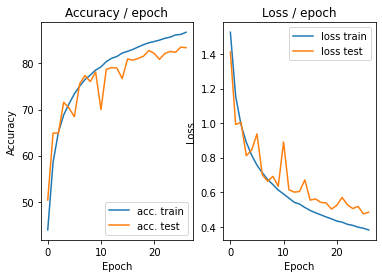

=== EPOCH 28 =====

[TRAIN Batch 000/391]	Time 0.192s (0.192s)	Loss 0.3600 (0.3600)	Prec@1  88.3 ( 88.3)	Prec@5 100.0 (100.0)


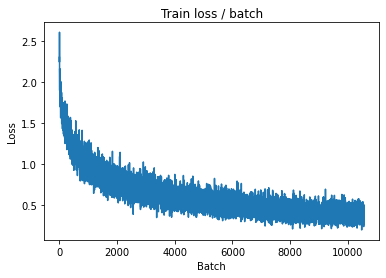

[TRAIN Batch 200/391]	Time 0.078s (0.037s)	Loss 0.2961 (0.3786)	Prec@1  89.8 ( 86.8)	Prec@5 100.0 ( 99.6)


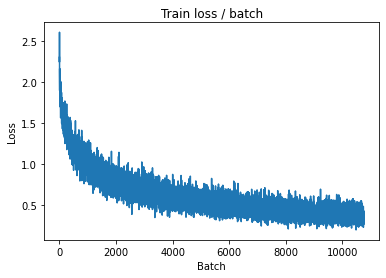


===============> Total time 14s	Avg loss 0.3816	Avg Prec@1 86.77 %	Avg Prec@5 99.52 %

[EVAL Batch 000/079]	Time 0.183s (0.183s)	Loss 0.4370 (0.4370)	Prec@1  85.9 ( 85.9)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.5058	Avg Prec@1 82.99 %	Avg Prec@5 98.99 %



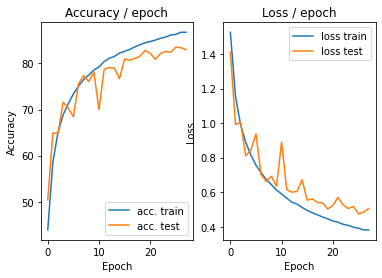

=== EPOCH 29 =====

[TRAIN Batch 000/391]	Time 0.187s (0.187s)	Loss 0.4227 (0.4227)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


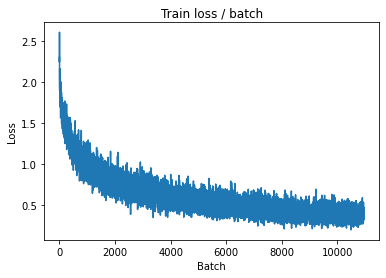

[TRAIN Batch 200/391]	Time 0.038s (0.039s)	Loss 0.2898 (0.3714)	Prec@1  88.3 ( 86.9)	Prec@5  99.2 ( 99.6)


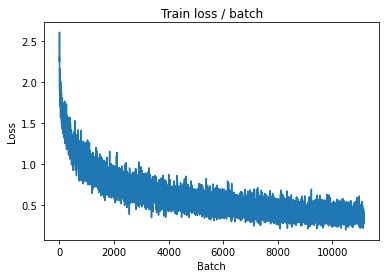


===============> Total time 14s	Avg loss 0.3741	Avg Prec@1 86.84 %	Avg Prec@5 99.58 %

[EVAL Batch 000/079]	Time 0.169s (0.169s)	Loss 0.4253 (0.4253)	Prec@1  85.9 ( 85.9)	Prec@5  99.2 ( 99.2)

===============> Total time 2s	Avg loss 0.4802	Avg Prec@1 83.25 %	Avg Prec@5 99.23 %



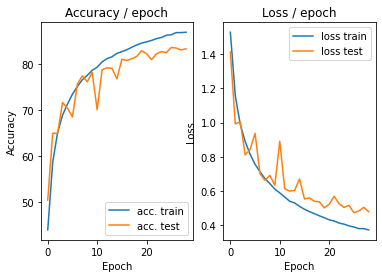

=== EPOCH 30 =====

[TRAIN Batch 000/391]	Time 0.202s (0.202s)	Loss 0.4283 (0.4283)	Prec@1  82.8 ( 82.8)	Prec@5 100.0 (100.0)


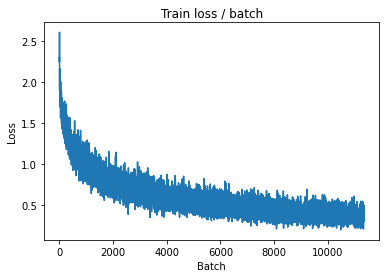

[TRAIN Batch 200/391]	Time 0.065s (0.038s)	Loss 0.4214 (0.3673)	Prec@1  85.9 ( 87.3)	Prec@5  99.2 ( 99.5)


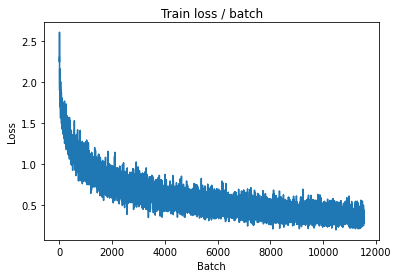


===============> Total time 15s	Avg loss 0.3671	Avg Prec@1 87.19 %	Avg Prec@5 99.54 %

[EVAL Batch 000/079]	Time 0.157s (0.157s)	Loss 0.4104 (0.4104)	Prec@1  87.5 ( 87.5)	Prec@5  98.4 ( 98.4)

===============> Total time 2s	Avg loss 0.4946	Avg Prec@1 83.24 %	Avg Prec@5 99.17 %



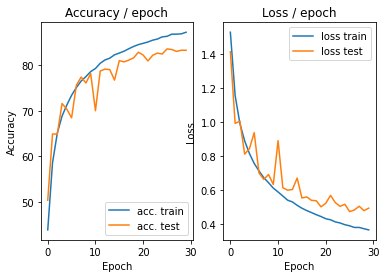

In [ ]:
main(128, 0.1, epochs=30, cuda=True)